<a href="https://colab.research.google.com/github/PrashanthKumar0/finance-app/blob/master/exponential_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch     1 | Total=1.000e+02 | Phys=1.256e-02 | IC=1.000e+00
Epoch   500 | Total=1.021e+00 | Phys=9.957e-01 | IC=2.506e-04
Epoch  1000 | Total=7.210e-03 | Phys=6.632e-03 | IC=5.789e-06
Epoch  1500 | Total=3.110e-03 | Phys=3.106e-03 | IC=4.073e-08
Epoch  2000 | Total=1.142e-03 | Phys=1.142e-03 | IC=1.751e-09
Epoch  2500 | Total=5.351e-04 | Phys=5.349e-04 | IC=2.319e-09
Epoch  3000 | Total=4.526e-04 | Phys=4.526e-04 | IC=2.667e-10
Epoch  3500 | Total=4.951e-04 | Phys=4.947e-04 | IC=3.489e-09
Epoch  4000 | Total=5.889e-03 | Phys=5.772e-04 | IC=5.312e-05
Epoch  4500 | Total=4.671e-04 | Phys=4.670e-04 | IC=1.051e-09
Epoch  5000 | Total=2.227e-02 | Phys=1.879e-03 | IC=2.039e-04

MSE (PINN vs exact) = 0.00045913874


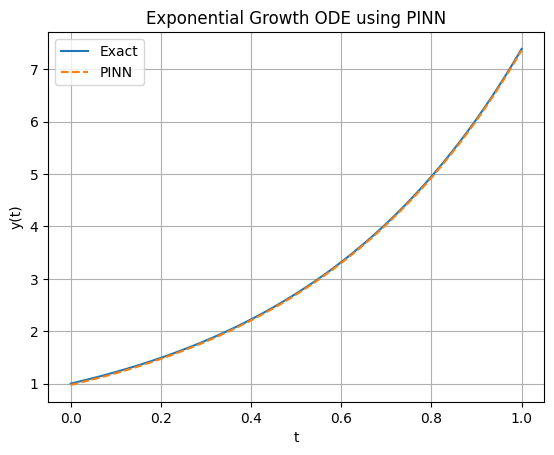

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# -----------------------------
# Problem: dy/dt = a*y, y(0)=y0
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

a = 2.0     # choose any a
y0 = 1.0    # choose any y0
t_min, t_max = 0.0, 1.0

N_f = 2000          # collocation points (physics points)
epochs = 5000
lr = 1e-3
lambda_ic = 100.0   # IC loss weight

np.random.seed(0)
torch.manual_seed(0)

# -----------------------------
# Neural Network y_theta(t)
# -----------------------------
class PINN(nn.Module):
    def __init__(self, hidden=64, depth=3):
        super().__init__()
        layers = [nn.Linear(1, hidden), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(hidden, hidden), nn.Tanh()]
        layers += [nn.Linear(hidden, 1)]
        self.net = nn.Sequential(*layers)

        # Xavier init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        return self.net(t)

model = PINN(hidden=64, depth=3).to(device)

# -----------------------------
# Collocation points (t) for physics residual
# -----------------------------
t_f = np.random.uniform(t_min, t_max, (N_f, 1)).astype(np.float32)
t_f = torch.tensor(t_f, device=device, requires_grad=True)

# Initial condition point t=0
t0 = torch.tensor([[0.0]], device=device, requires_grad=True)
y0_true = torch.tensor([[y0]], device=device)

# -----------------------------
# Loss: MSE(r(t)) + lambda*MSE(IC)
# r(t) = dy_theta/dt - a*y_theta
# -----------------------------
def pinn_loss():
    y_pred = model(t_f)

    dy_dt = torch.autograd.grad(
        outputs=y_pred,
        inputs=t_f,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True
    )[0]

    r = dy_dt - a * y_pred                      # physics residual
    loss_phys = torch.mean(r**2)

    y0_pred = model(t0)                         # IC residual
    loss_ic = torch.mean((y0_pred - y0_true)**2)

    loss = loss_phys + lambda_ic * loss_ic
    return loss, loss_phys.detach(), loss_ic.detach()

# -----------------------------
# Train (Adam)
# -----------------------------
opt = torch.optim.Adam(model.parameters(), lr=lr)

for ep in range(1, epochs + 1):
    opt.zero_grad()
    loss, lp, lic = pinn_loss()
    loss.backward()
    opt.step()

    if ep % 500 == 0 or ep == 1:
        print(f"Epoch {ep:5d} | Total={loss.item():.3e} | Phys={lp.item():.3e} | IC={lic.item():.3e}")

# -----------------------------
# Test vs analytical solution
# y(t) = y0 * exp(a t)
# -----------------------------
t_test = np.linspace(t_min, t_max, 400).reshape(-1, 1).astype(np.float32)
t_test_t = torch.tensor(t_test, device=device)

with torch.no_grad():
    y_pinn = model(t_test_t).cpu().numpy()

y_true = y0 * np.exp(a * t_test)

mse = np.mean((y_pinn - y_true)**2)
print("\nMSE (PINN vs exact) =", mse)

# -----------------------------
# Plot
# -----------------------------
plt.figure()
plt.plot(t_test, y_true, label="Exact")
plt.plot(t_test, y_pinn, "--", label="PINN")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.title("Exponential Growth ODE using PINN")
plt.grid(True)
plt.legend()
plt.show()